In [59]:
import cv2
import numpy as np

print(f"OpenCV version is: {cv2.__version__}")

if True:  # change to True if you want to use the notebook locally
    # and use cv2_imshow from matplotlib (eg. Vscode)
    import matplotlib.pyplot as plt

    def cv2_imshow(img):
        plt.figure(figsize=(10,10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.show()

OpenCV version is: 4.10.0


# Task 1

In [60]:
GREEN = (0, 255, 0)
RED = (0, 0, 255)

def draw_quadrilateral(img, p_list, color, girth):
    shifted = np.concat([p_list[-1:],p_list[:-1]]).astype(int)
    zip_list = list(zip(p_list, shifted))

    for (p1, p2) in zip_list:
        cv2.line(img, p1, p2, color, girth)

def draw_square(img, p1, p3, color, girth):
    p_matrix = np.vstack([p1, p3])
    new = (p_matrix * np.eye(2), p_matrix * np.array([0,1,1,0]).reshape(2,2))

    p2, p4 = list(map(lambda x: x[np.nonzero(x)], new))
    p4 = p4[::-1]

    p_list = np.array([p1, p2, p3, p4]).astype(int)
    draw_quadrilateral(img, p_list, color, girth)

def drawMarkers(img, corners, ids):
    if ids is None:
        return

    square_size = 7
    for i in range(ids.shape[0]):
        c = corners[i][0]
        id = ids[i][0]
        draw_quadrilateral(img, c.astype(int), GREEN, 1)
        draw_square(img, c[0] - (square_size // 2), c[0] + (square_size // 2), RED, 1)
        cv2.putText(img, f"{id}", c[0].astype(int), cv2.FONT_HERSHEY_SIMPLEX, 1, RED, 2)

In [61]:
def input_parse(img = None, filename = None):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        assert False

    return current

In [62]:
def get_objpoints(shape, width, uniform_grid = True):
    x, y = shape

    if uniform_grid:
        arr1 = np.linspace(0, width * x, x + 1), 
        arr2 = np.linspace(0, width * y, y + 1)
    else:
        arr1, arr2 = [0], [0]
        for i in range(x):
            arr1.append(arr1[i] + width[i % len(width)])
        for i in range(y):
            arr2.append(arr2[i] + width[i % len(width)])

    xx, yy = np.meshgrid(arr1, arr2)
    xx, yy = xx.reshape(-1), yy.reshape(-1)
    objarr = np.vstack([xx, yy, np.zeros(len(xx))]).T

    return objarr.astype(np.float32)

def get_marker_objp(width):
    objp = get_objpoints((1,1), width)
    objp[[2,3]] = objp[[3,2]]
    return objp

get_objpoints((3,5), [168, 70], False)
''

''

In [63]:
def find_aruco_info(img = None, filename = None):
    img = input_parse(img, filename)
    
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_16h5)
    parameters = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)

    corners, ids, _ = detector.detectMarkers(img)

    img_ = img.copy()
    drawMarkers(img_, corners, ids)
    corners = np.array(list(corners)).reshape(-1,4,1,2)

    return (corners, ids)

def permute_corners(corners):
    corners = corners.reshape(-1,1,2)
    perm = np.array([0,1,4,5,3,2,7,6])
    coords = np.arange(len(perm))

    for i in range(3):
        corners[coords + (i * len(perm))] = corners[perm + (i * len(perm))]

    return corners

find_aruco_info(filename = 'data1/img1.png')
''

''

In [64]:
TAG_SIDE=168
SPACING=70
TAG_GRID=(3,5)

def calibrate(img = None, filename = None, use_grid = False):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)

    corners = find_aruco_info(img = current)[0]
    if use_grid:
        corners = [permute_corners(corners)]
        objpoints = [get_objpoints(TAG_GRID, [TAG_SIDE, SPACING], False)]
    else:
        objpoints = [get_marker_objp(TAG_SIDE)] * 6

    return (
        cv2.calibrateCamera(
            objectPoints = objpoints,
            imagePoints = corners,
            imageSize = gray.shape[::-1],
            cameraMatrix = None,
            distCoeffs = None,
        ),
        objpoints,
        corners,
    )

calibrate(filename = 'data1/img1.png', use_grid = True)
''


''

In [65]:
def get_projection_error(cMat, dCoeff, rvecs, tvecs, objpoints, imgpoints):
    total_error = 0
    total_points = 0

    for i in range(len(objpoints)):
        imgpoints2, _ = cv2.projectPoints(
            objpoints[i],
            rvecs[i],
            tvecs[i],
            cMat,
            dCoeff,
        )

        error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)
        total_error += error ** 2
        total_points += len(objpoints[i]) 

    mean_error = np.sqrt(total_error / total_points)
    return mean_error


def get_undistort_rectify(img = None, filename = None, use_grid = False, alpha = 0):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    gray = cv2.cvtColor(current, cv2.COLOR_BGR2GRAY)
    size = gray.shape[::-1]

    cal = calibrate(img = current, use_grid = use_grid)
    ((_, cMat, dCoeff, rvecs, tvecs), oP, iP) = cal

    projection_error = get_projection_error(cMat, dCoeff, rvecs, tvecs, oP, iP)

    newCMat, _ = cv2.getOptimalNewCameraMatrix(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        imageSize = size,
        alpha = alpha,
        newImgSize = size,
    )

    undistort, rectify = cv2.initUndistortRectifyMap(
        cameraMatrix = cMat,
        distCoeffs = dCoeff,
        R = np.eye(3),
        newCameraMatrix = newCMat,
        size = size,
        m1type = cv2.CV_32FC1,
    )

    return (undistort, rectify, projection_error)

In [66]:

def undistort(img = None, filename = None, use_grid = False):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    (undistort, rectify, err) = get_undistort_rectify(img = current, use_grid = use_grid)

    print(f"Mean reprojection error : {err}")

    undistorted = cv2.remap(
        src = current,
        map1 = undistort,
        map2 = rectify,
        interpolation = cv2.INTER_LINEAR,
    )

    return undistorted

Original image:


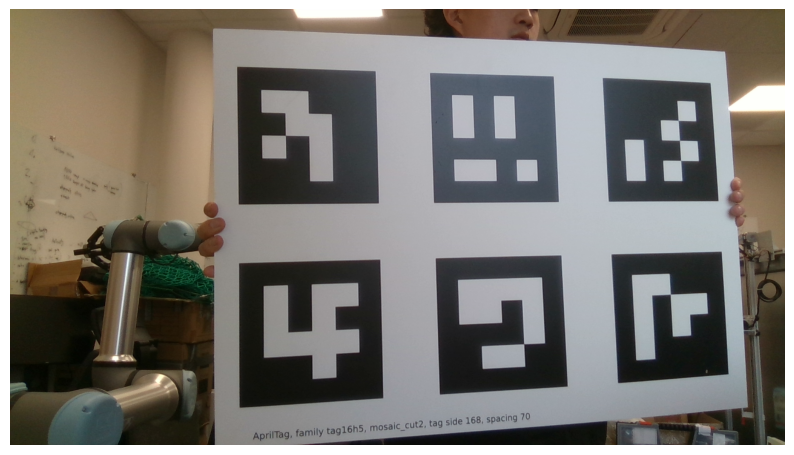

With grid usage:
Mean reprojection error : 0.894211073026517


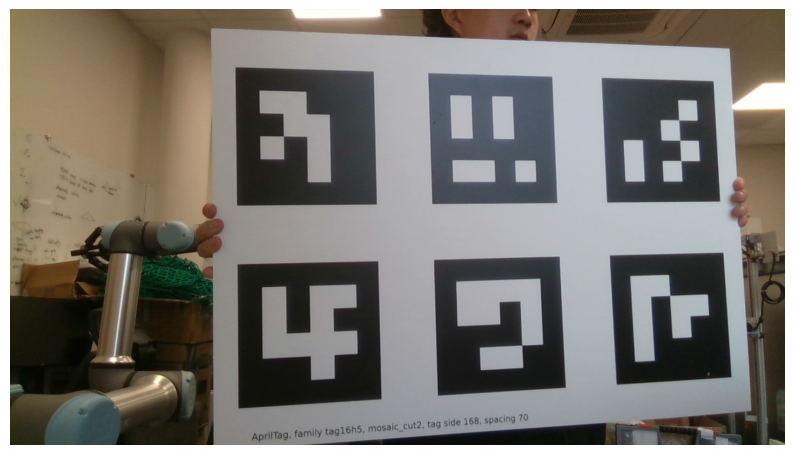

Without grid usage:
Mean reprojection error : 0.3035841631654325


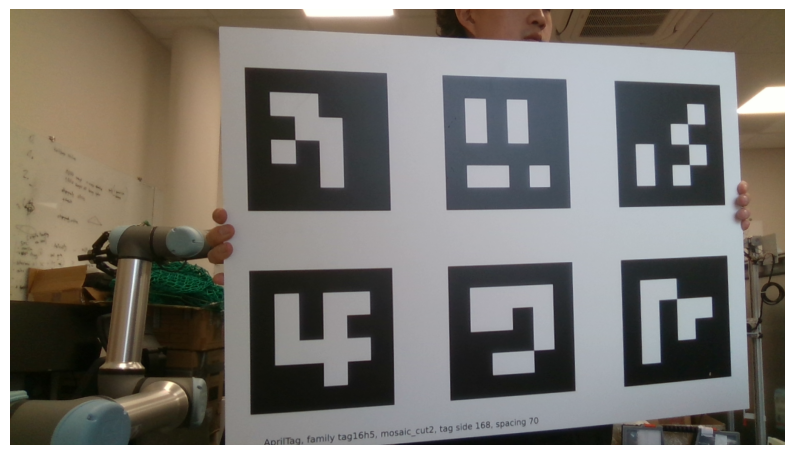

In [67]:

print("Original image:")
cv2_imshow(cv2.imread('data1/img1.png'))
print("With grid usage:")
img = undistort(filename = 'data1/img1.png', use_grid = True)
cv2_imshow(img)
print("Without grid usage:")
img = undistort(filename = 'data1/img1.png', use_grid = False)
cv2_imshow(img)

# Comment on the results

I checked if the lines are straight on images produced by both methods and on the original image. In my opinion, the image produced with all available information is clearly superior. The edges of the board are really straight, and when you flip between undistorded and original image, you can actually see the distosion.

However, that method also results with higher reprojection error. This might be because i made a mistake, but on the other hand it also makes sense. It is easier to make 6 different transformations to fit 6 sets of points, than making one that should fit all the points combined.

# Task 2

In [68]:
# def find_corners(coords):
#     coords = coords.T
#     corners = []
#     x_signs = [1, -1, -1, 1]
#     y_signs = [1, 1, -1, -1]
#     for xs, ys in list(zip(x_signs, y_signs)):
#         corner_idx = np.argmin(coords[:, 0] * xs + coords[:, 1] * ys)
#         corners.append(coords[corner_idx])

#     return np.array(corners)

In [96]:
def find_span(coords):
    col = coords[:, 0]
    xspan = [np.min(col), np.max(col)]
    col = coords[:, 1]
    yspan = [np.min(col), np.max(col)]
    return np.vstack([xspan, yspan])

def multiply_coords_matrix(range_x, range_y, matrix):
    xx, yy = np.meshgrid(np.arange(*range_x), np.arange(*range_y))
    length = (range_x[1] - range_x[0]) * (range_y[1] - range_y[0])
    stack_list = [xx.flatten(), yy.flatten(), np.ones(length)]
    xy1_vectors = np.stack(stack_list, axis=1).astype(int)

    new_coords = matrix @ xy1_vectors.T
    last_row = new_coords[-1, :] 
    new_coords = np.round(new_coords / last_row).astype(int)
    return new_coords

def transform(tx, ty, matrix):
    transform_matrix = np.array([1,0,tx,0,1,ty,0,0,1]).reshape(3,3)
    new_coords = transform_matrix @ matrix
    last_row = new_coords[-1, :] 
    new_coords = np.round(new_coords / last_row).astype(int)
    return new_coords

In [97]:
def pixel_list_to_img(w, h, array):
    array = array.reshape(w, h, 3)
    return array.astype(np.uint8)

def cut_to_dimensions(width, heigth, matrix):
    correct_points = []
    for p in matrix:
        if p[0] < 0 or p[0] >= width or p[1] < 0 or p[1] >= heigth:
            #last row is set to be black
            correct_points.append(np.array([0, heigth]))
        else:
            correct_points.append(p)

    return np.array(correct_points).astype(int)

def find_colors(point_coords, img):
    _, w, _ = img.shape
    black_row = np.zeros((1, w, 3), dtype=np.uint8)
    img = np.vstack([img, black_row])
    x_coords, y_coords = point_coords[:, 0], point_coords[:, 1]

    return img[y_coords, x_coords]

[[-100  707]
 [   0  719]]
(720, 1280, 3)
(719, 807, 3)


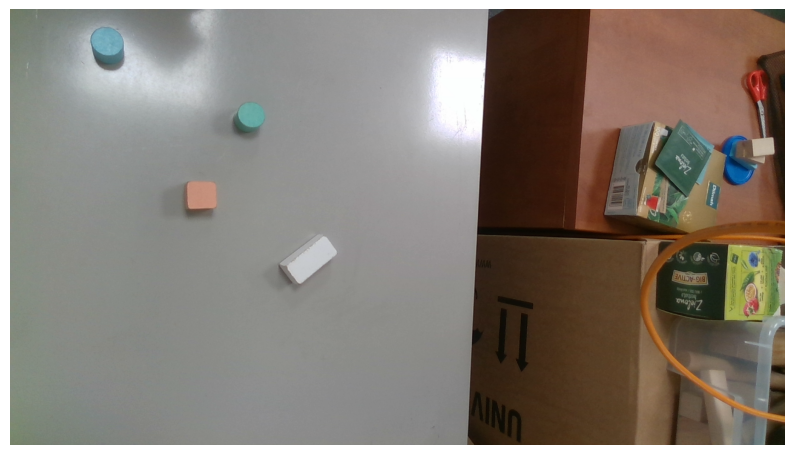

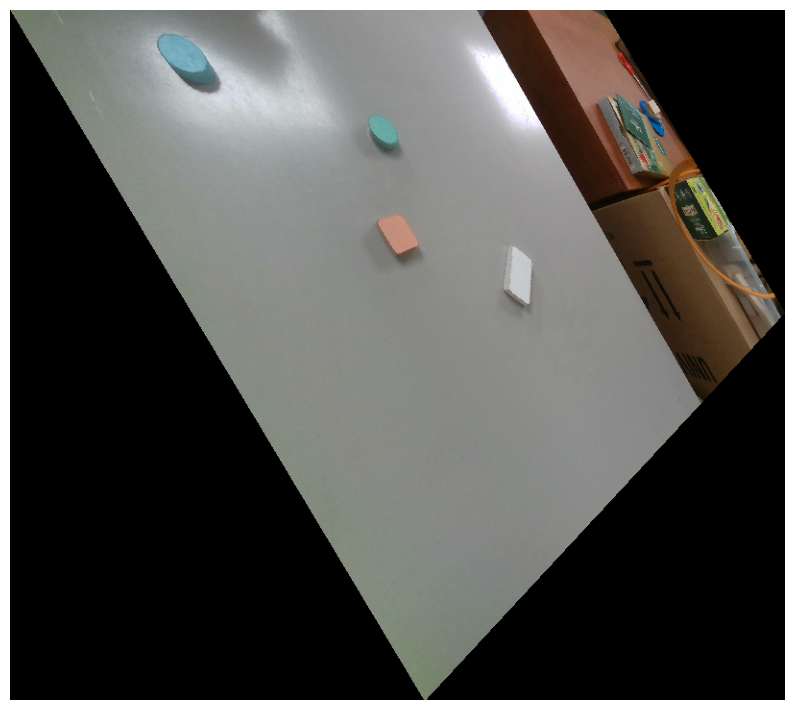

In [138]:
def apply_homography(homography, filename = None, img = None):
    if filename is not None:
        current = cv2.imread(filename)
    elif img is not None:
        current = img
    else:
        return None

    h, w, _ = current.shape

    new_coords = multiply_coords_matrix([0,w], [0,h], homography).T 

    span = find_span(new_coords)
    new_h, new_w = list(span[:, 1] - span[:, 0])

    print(span)

    inv_homography = np.linalg.inv(homography)
    original_cords = multiply_coords_matrix(span[0, :], span[1, :], inv_homography)
    original_cords = original_cords.T
    original_cords = cut_to_dimensions(w, h, original_cords[:, [0,1]])
    
    new_colors = find_colors(original_cords, current)
    new_image = pixel_list_to_img(new_w, new_h, new_colors)
    print(current.shape)
    print(new_image.shape)
    cv2_imshow(current)
    cv2_imshow(new_image)

def img_identity(img):
    current = img
    h, w, _ = current.shape

    new_coords = multiply_coords_matrix(w, h, np.eye(3)).T
    new_colors = find_colors(new_coords, current)
    new_image = pixel_list_to_img(w, h, new_colors)

    cv2_imshow(new_image)

imgpath = 'data2/img1.png'
trapezoid_homography = np.array([1,0.6,-100,0,1,0,0.001,0,1]).reshape(3,3)
apply_homography(filename=imgpath, homography = trapezoid_homography)

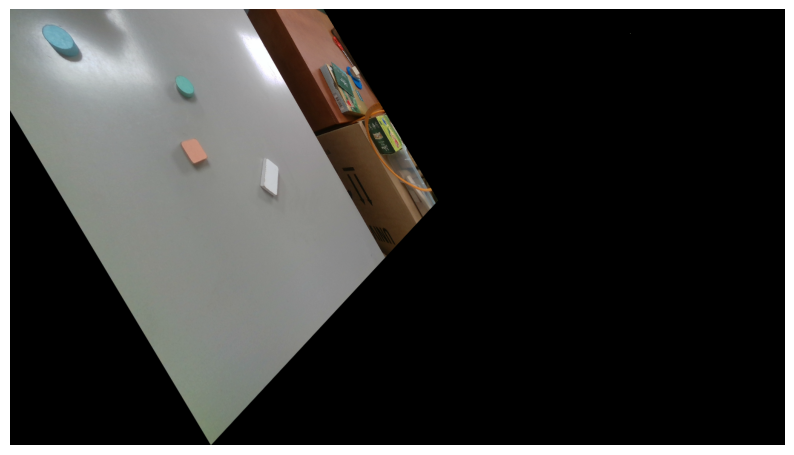

In [137]:
image = cv2.imread(imgpath)
height, width = image.shape[:2]
warped_image = cv2.warpPerspective(image, trapezoid_homography, (width, height))
cv2_imshow(warped_image)